In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from step_shGLM_v2 import step_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
T_syn = 250
T_hist = 250
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 2
hist_basis_no = 2
prop_basis_no = 2


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = step_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)
#model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/gumbelv2_sub5_s2_h2_shglm_i5000.pt"))
model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:48000]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([8000])


In [5]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37000
37000


In [7]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


157


In [ ]:
batch_no = 10000
loss_array = np.empty((batch_no//100, 2))
#bce_loss = nn.BCELoss(reduction="mean")

#train_zeros = torch.zeros(batch_size, sub_no).cuda()
#test_zeros = 

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred, train_raw, train_spikes = model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    var_loss = torch.var(diff)
    spike_loss = torch.mean(train_spikes **2)
    loss = var_loss + 1*spike_loss
    #print(i, var_loss.item(), spike_loss.item())
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred, test_raw, test_spikes = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/burst_L23_stepS_finalspike_bigzeroconstraint_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/cont_shglm/burst_L23_stepS_finalspike_bigzeroconstraint_test_scores.npy", loss_array)


<ipython-input-8-175281948118>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 67.24904372212622 7.493990370521786e-05 5.752859985219683e-05
[0.58812505 0.00575    0.         0.         0.        ]
TEST 50 65.2745793904314 0.02943322152631389 0.02790160410859388
[0.0005     0.22887501 0.         0.37800002 0.40375003]
TEST 100 61.23578587344818 0.08948598400621721 0.08428709827369751
[3.7500000e-04 2.9762501e-01 0.0000000e+00 3.9525002e-01 2.7825001e-01]
TEST 150 58.56418949379839 0.1292099119882678 0.1363999104192971
[3.7500000e-04 2.2412501e-01 0.0000000e+00 4.6712503e-01 2.6987502e-01]
TEST 200 55.994379134336526 0.1674203850937206 0.14936778895015212
[0.0005     0.20400001 0.00075    0.340375   0.23200001]
TEST 250 53.7320671778498 0.20105866892139157 0.1807858610744455
[3.7500000e-04 2.0937501e-01 1.1250001e-03 4.2537501e-01 2.7450001e-01]
TEST 300 52.5626247146079 0.21844709196265566 0.1861754408823153
[0.000375   0.17587501 0.0015     0.32337502 0.328     ]
TEST 350 49.88952345290847 0.2581933960338888 0.2325830915256354
[0.000375 0.209625 0.001375 

TEST 3350 24.157361994472648 0.6408045332068804 0.5376861796163231
[0.00025    0.17187501 0.001      0.143625   0.11975001]
TEST 3400 24.289902503249632 0.6388337902982836 0.6505694809105484
[0.00025    0.17312501 0.001125   0.149      0.13700001]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TEST 4700 23.614803853302032 0.6488718223424852 0.616325396092329
[0.00025    0.15262501 0.001125   0.137125   0.140625  ]
TEST 4750 23.21082251066895 0.6548786151684174 0.5718859329549099
[0.00025    0.146375   0.001125   0.18037501 0.122375  ]
TEST 4800 23.602563659598687 0.6490538216090451 0.6467574159058308
[0.00025    0.15025    0.001125   0.11350001 0.14187501]
TEST 4850 23.753642263641268 0.6468074360737888 0.6117972352888768
[0.00025    0.16275    0.001      0.13887501 0.1365    ]
TEST 4900 23.54572239436606 0.6498989935709294 0.6506354436034445
[0.00025    0.156625   0.001      0.134625   0.13550001]
TEST 4950 23.535389261016263 0.6500526367989057 0.6445676375396274
[0.00025    0.15925    0.001      0.149875   0.12837501]


# Test 

In [6]:
model = step_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/burst_L23_stepS_finalspike_bigzeroconstraint_i4900.pt"))
model = model.float().to("cuda")

V_ref = np.fromfile("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()
V_ref = V_ref[:48000]

test_V_ref = V_ref[train_T:train_T+test_T]


In [7]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")


test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final, raw, spikes = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()
raw = raw.cpu().detach().numpy()
spikes = spikes.cpu().detach().numpy()
#probs = probs.cpu().detach().numpy()

0.48694341899078664


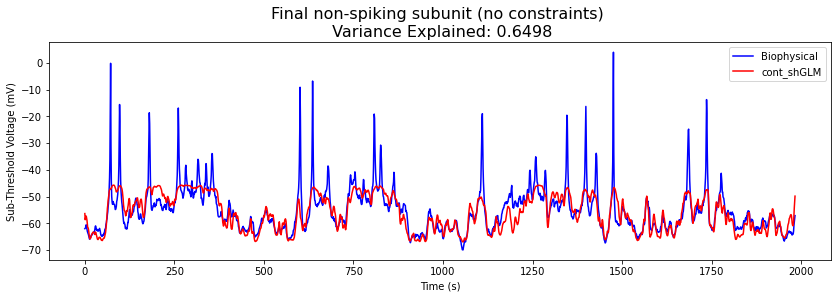

In [14]:
plt.figure(figsize = (14,4))
delay = 16

plt.plot(test_V_ref[delay:2000], label="Biophysical", c="blue")
plt.plot(test_V_final[:2000-delay]-32, label="cont_shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref[delay:],
                                                      y_pred=test_V_final[:-delay],
                                                      multioutput='uniform_average')

plt.title("Final non-spiking subunit (no constraints) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


#plt.savefig("/media/hdd01/sklee/cont_shglm/final_nospike_noconstraint.png", dpi=150, bbox_inches='tight')#

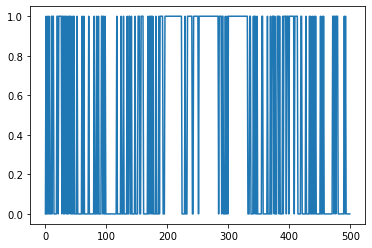

In [15]:
plt.plot(spikes[:500,1])
#print(spikes)


In [20]:
output_save = np.vstack((test_V_ref.reshape((1,-1)), test_V_final.reshape((1,-1))))
print(output_save.shape)
dend_save = raw.T
spikes_save = spikes.T
probs_save = probs.T
print(dend_save.shape)
print(spikes_save.shape)
print(probs_save.shape)

np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_V.npy", output_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_dend.npy", dend_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_spikes.npy", spikes_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_probs.npy", probs_save)

(2, 8000)
(4, 8000)
(4, 8000)
(4, 8000)


In [9]:
for name, param in model.named_parameters():
    print(name, param.data)

W_s_syn tensor([[[ 0.3636, -0.0067],
         [ 0.8123, -0.1821]],

        [[ 0.1648, -0.5033],
         [ 0.7889, -1.2196]],

        [[ 0.7365, -0.2357],
         [ 0.3847, -0.7768]],

        [[ 0.3431, -0.3001],
         [ 0.7582, -1.3856]],

        [[ 0.4279, -0.4513],
         [ 0.7921, -1.6215]]], device='cuda:0')
W_ns_syn tensor([[[-0.0576, -0.0070],
         [-0.0134, -0.4550]],

        [[ 0.3826, -0.0642],
         [ 0.5320, -0.7127]],

        [[ 0.1131,  0.0767],
         [ 0.4038, -0.6421]],

        [[ 0.1513,  0.1549],
         [ 0.3450, -0.5999]],

        [[ 0.4452, -0.1257],
         [ 0.5046, -0.7934]]], device='cuda:0')
Tau_s_syn tensor([[ 0.2074, -0.8053],
        [ 1.7283,  1.6129]], device='cuda:0')
Tau_ns_syn tensor([[-0.1851,  0.1265],
        [ 2.0884,  1.3127]], device='cuda:0')
Delta_s_syn tensor([[ 0.0329,  0.0899],
        [ 0.3123,  1.2051],
        [ 0.5550,  1.0877],
        [-0.0674,  0.3695],
        [ 0.2636,  0.8822]], device='cuda:0')
Delta_ns_s